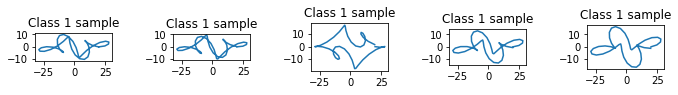

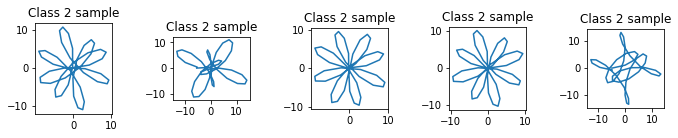

Labels shape (class 1 or 2): (10000, 1)
Attribute labels shape (continuous): (10000, 2)
Shape vectors: (10000, 100)


In [46]:
#
# implement a simple generative linear model with two "attributes", one that
# stretches the initial shape (average shape) vertically, and one that stretches it 
# horizontally. Of course, these attributes can be any linear transformation 
#



import matplotlib.pyplot as plt
import numpy as np

pi = 3.1415

arc = 350
radius = 10
number_of_samples = 3
vec_length = 100 # make sure it's even


def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

thetas = np.linspace(0, arc*pi/180, int(vec_length/2))
magni = radius * np.ones((1, int(vec_length/2))) * np.sin(np.linspace(0, 8*pi, int(vec_length/2)))

x, y = pol2cart(magni, thetas)
average = np.reshape(np.array([x, y]), (vec_length, 1))

attribute1 = np.zeros((vec_length, 1)) # horizontal stretch 
attribute1[:int(vec_length/2)] = np.reshape(np.cos(thetas), (-1, 1))
attribute2 = np.zeros((vec_length, 1)) # vertical stretch 
attribute2[int(vec_length/2):] = np.reshape(np.sin(thetas), (-1, 1))

attributes = np.squeeze(np.array((attribute1, attribute2)))


## generate training data 
#
# we'll say that the shapes with specific linear combinations of the attributes 
# are of one class, the rest of another 
# 
# in the example below, anything that is stretched vertically with a weight of 20 is 
# class 1, the rest are in class 2 
#

# generate 5 class 1 examples
number_of_samples = 5
attribute_sampler = np.random.randn(number_of_samples, 2) * 5 
attribute_sampler[:, 0] = 20 ## this attribute (horizontal stretch is exxagerated to make the sample class 1)
shapes = np.matmul(attribute_sampler, attributes).T + np.tile(average, (number_of_samples, ))
 
attribute_sampler
    
fig, ax = plt.subplots(1, number_of_samples, figsize=(10, 10))
fig.tight_layout(pad=3)
## plot them below to see what the individual components of the linear model do
for sample in range(number_of_samples):
# generate x samples given combined weight (same weight for all attributes)
    x = shapes[:int(vec_length/2), sample]
    y = shapes[int(vec_length/2):, sample]
    ax[sample].plot(x, y)
    ax[sample].set_aspect('equal')
    ax[sample].set_title("Class 1 sample")
plt.show()



# generate 5 class 2 examples
number_of_samples = 5
attribute_sampler = np.random.randn(number_of_samples, 2) * 5  # all attributes are normally distributed with 
                                                               # zero mean and s.t.d. 5 

shapes = np.matmul(attribute_sampler, attributes).T + np.tile(average, (number_of_samples, ))
 
attribute_sampler
    
fig, ax = plt.subplots(1, number_of_samples, figsize=(10, 10))
fig.tight_layout(pad=3)
## plot them below to see what the individual components of the linear model do
for sample in range(number_of_samples):
# generate x samples given combined weight (same weight for all attributes)
    x = shapes[:int(vec_length/2), sample]
    y = shapes[int(vec_length/2):, sample]
    ax[sample].plot(x, y)
    ax[sample].set_aspect('equal')
    ax[sample].set_title("Class 2 sample")
plt.show()



### you can use this as input to an MLP 

number_of_samples = 10000 # half of them will be class 1, half will be class 2
labels = np.ones((number_of_samples, 1))
labels[int(number_of_samples/2):, :] = 2

# generate 
attribute_sampler = np.random.randn(int(number_of_samples/2), 2) * 5 
attribute_sampler[:, 0] = 20 ## this attribute (horizontal stretch is exxagerated to make the sample class 1)

attribute_labels = np.array(attribute_sampler)

X1 = (np.matmul(attribute_sampler, attributes).T + np.tile(average, (int(number_of_samples/2), ))).T

attribute_sampler = np.random.randn(int(number_of_samples/2), 2) * 5 
X2 = (np.matmul(attribute_sampler, attributes).T + np.tile(average, (int(number_of_samples/2), ))).T

attribute_labels = np.concatenate((attribute_labels, attribute_sampler), axis=0)

X = np.concatenate((X1, X2), axis=0)




print("Labels shape (class 1 or 2): " + str(np.shape(labels)))
print("Attribute labels shape (continuous): " + str(np.shape(attribute_labels)))
print("Shape vectors: " + str(np.shape(X)))






In [40]:
attribute_sampler

array([[-4.28756991, -6.17281959],
       [-1.12274135,  0.64289327],
       [ 0.07147487,  2.18356654],
       ...,
       [-0.97259053,  6.65438271],
       [-8.53751348, -0.39979006],
       [12.20293329,  3.09573609]])